In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
np.random.seed(100)

# 近似ベイズ：変分推論
ベイズ推論に置いて、パラメータの推論が解析的に行えないケースがある。例えば、確率変数が非線形な関係にあるとか、確率変数同士が共役関係にないなどの場合。このような場合には近似的に推論を行う必要がある。

ベイズ推論の枠では、よく使われる近似推論手法として大きく分けて二つの手法がある。
- MCMC：サンプリングに基づく推論
- 変分推論：最適化に基づく推論

ここでは変分推論によって近似ベイズ推論を実装してみる。

## 変分推論
変分推論とは求めたい事後確率分布$p(Z|X)$を別の関数$q(Z;\xi)$を使って近似する手法。

関数qは、$q(Z;\xi) = \prod^{M} q_{i}(Z_i | \xi)$とする平均場近似を使うことが多い。
平均場近似を適用すると、$Z_i$に対する最適関数は以下のようになり、初期値をを決めてM個の関数を順々に更新していくことを繰り返していくことで最適化ができる。

$$
\begin{eqnarray}
  \ln q^{*}_{j}(\mathbf{Z}_j | \xi) = \mathbb{E}_{i\neq j}\left[\ln p(\mathbf{X}, \mathbf{Z})\right] + \mathrm{const.}
\end{eqnarray}
$$

# 実装2:１変数ガウス分布のパラメータ推論
単純な例として、1変数ガウス分布のパラメータ推論を行ってみる。

## モデル
N個のデータ$X=\{x_1, x_2, \cdots, x_N\}$が得られている。このデータ$X$はガウス分布$\mathcal{N}(x_n|\mu, \tau^{-1})$に従うものとする。

$$
x_n \sim p(x_n | \Theta) = \mathcal{N}(x_n|\mu, \tau^{-1})
$$

ここで、$\mu$は平均、$\tau$は精度(分散の逆数)を示すパラメータの確率変数。

$$
\begin{align}
    &\mu \sim \mathcal{N}(\mu | \mu_0, (\lambda_0 \tau)^{-1}) \\
    &\tau \sim \mathrm{Gamma}(\tau | a_0, b_0)
\end{align}
$$

変分推論を適用するにあたって、以下のように、 $\{\mu, \tau\}$を分解して近似する(平均場近似)。

$$
q(\mu, \tau) = q(\mu)q(\tau)
$$

変分推論における最適解の一般解に上記のモデルを当てはめることで、$\{\mu, \tau\}$について以下の最適解が得られる。

平均$\mu$に対する最適関数は上述の式を当てはめて展開していくと以下の通りとなる。

$$
\begin{align}
    q^{*}_{\mu}(\mu) &= \mathcal{N}(\mu | \mu_N, \lambda^{-1}_N) \\
        \mu_N &= \frac{\lambda_0\mu_0 + N \bar{x}}{\lambda_0 + N} \\
        \lambda_N &= (\lambda_0 + N)\mathbb{E}[\tau]
\end{align}
$$

精度$\tau$に対する最適関数は上述の式を当てはめて展開していくと以下の通りとなる。

$$
\begin{align}
    q^{*}_{\tau}(\tau) &= \mathrm{Gamm}(\tau | a_N, b_N) \\
        a_N &= a_0 + \frac{N+1}{2} \\
        n_N &= b_0 + \frac{1}{2}\mathbb{E}_{\mu}\left[\sum(x_n-\mu)^2 + \lambda_0(\mu - \mu_0)^2 \right]
\end{align}
$$

$\mu$はガウス分布、$\tau$はガンマ分布になる。
ガンマ分布の期待値$\mathbb{E}(\tau)$は$\mathbb{E}(\tau) = \frac{a_N}{b_N}$という一般的な事実を利用する。

事前分布のパラメータ$\mu_0 = \lambda_0 = a_0 = b_0 = 0$とすると、$\mu$の1次と2次のモーメントは次のようになる。

$$
\begin{align}
    &\mathbb{E}_{\mu}[\mu] = \bar{x} \\
    &\mathbb{E}_{\mu}[\mu^2] = \bar{x}^2 + \frac{1}{N\mathbb{E}[\tau]}
\end{align}
$$

精度$\tau$に対する最適関数のパラメータ$b_N$は以下の通りとなる。

$$
\begin{align}
    b_N = \frac{N}{2}\left(\bar{x^2} - \bar{x}^2 + \frac{1}{N\mathbb{E}(\tau)} \right)
\end{align}
$$

## サンプルデータ

Text(0.5, 0, 'x')

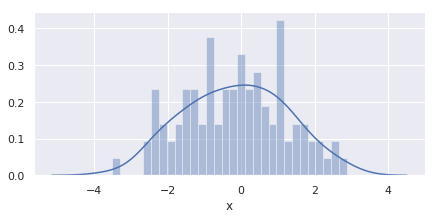

In [3]:
# 真の分布のパラメータ
mu = 0
tau = 0.5

# サンプル
N = 100
std = np.sqrt(1.0/tau)
X = np.random.normal(mu, std, N)

# Plot
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1,1)
sns.distplot(X, bins=30, ax=ax)
ax.set_xlabel('x')

## 推論

In [4]:
def q_mu(X, tau_e):
    mean_x = X.mean()
    N = len(X)
    mu_n = mean_x
    lambda_n = N * tau_e
    return mu_n, lambda_n

def q_tau(X, tau_e):
    mean_x = X.mean()
    mean_x2 = (X**2).mean()
    N = len(X)
    a_n = (N + 1) / 2.
    b_n = (N / 2.) * (mean_x2 - mean_x**2 + (1. / (N*tau_e)))
    return a_n, b_n

In [5]:
# initialize
tau_e = 1.0
taus = [tau_e]
n_iter = 10
for i in tqdm(np.arange(n_iter)):
    # q(mu)
    mu_n, lambda_n = q_mu(X, tau_e)
    # q(tau)
    a_n, b_n = q_tau(X, tau_e)
    # E[tau]の更新
    tau_e = a_n / b_n
    
    taus.append(tau_e)

100%|██████████| 10/10 [00:00<00:00, 21323.36it/s]


## 推論結果

### 期待値の推移

Text(0, 0.5, '$\\mathbb{E}(\\tau)$')

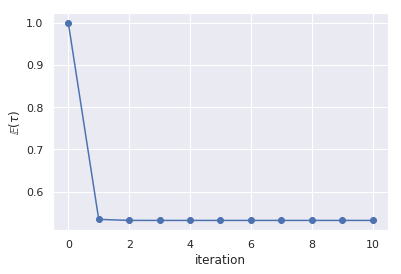

In [6]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
ax.plot(taus, 'o-')
ax.set_xlabel('iteration')
ax.set_ylabel('$\\mathbb{E}(\\tau)$')

### 事後分布

Text(0.5, 0, '$\\tau$')

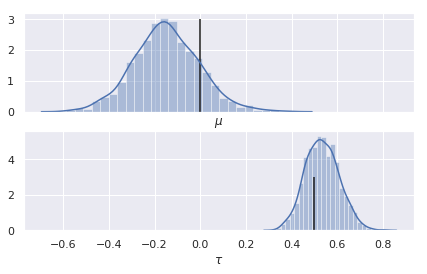

In [7]:
mu_sample = np.random.normal(mu_n, np.sqrt(1./lambda_n), 1000)
tau_sample = np.random.gamma(a_n, 1./b_n, 1000)

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(2,1, sharex=True)
sns.distplot(mu_sample, ax=ax[0])
ax[0].vlines(mu, 0, 3)
ax[0].set_xlabel('$\\mu$')
sns.distplot(tau_sample, ax=ax[1])
ax[1].vlines(tau, 0, 3)
ax[1].set_xlabel('$\\tau$')

### サンプルした分布

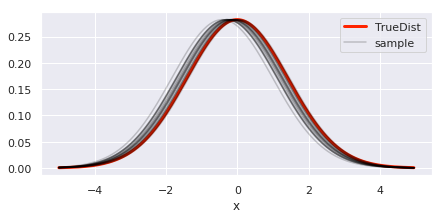

In [8]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1,1)

xs = np.arange(-5, 5, 0.05)
std = np.sqrt(1.0/tau)
p = stats.norm(mu, std).pdf(xs)
ax.plot(xs, p, color='#FF2400', lw=3, label='TrueDist')

ran = np.random.choice(1000, 20)
first = True
for r in ran:
    std_spl = np.sqrt(1.0/tau_sample[r])
    ps = stats.norm(mu_sample[r], std).pdf(xs)
    if first:
        ax.plot(xs, ps, color='#000000', alpha=0.2, label='sample')
        first=False
    else:
        ax.plot(xs, ps, color='#000000', alpha=0.2)
ax.set_xlabel('x')
ax.legend()

# 実装2:線形回帰

1変数の線形回帰モデルのパラメータを変分推論で近似推論してみる。

yはxとパラメータ$\mathbf{w}$に依存して以下のガウス分布にう従うとする(1次線形回帰モデル)。

$$
\begin{eqnarray}
  p(y_n | \mathbf{x}_{n}, \mathbf{w}) = \mathcal{N}(y_{n} | \left(w_0+w_1x \right), \sigma^{2}_{y})
\end{eqnarray}
$$

重み$\mathbf{w}=\{w_0, w_1\}$が従う分布としてガウス分布を仮定する。

$$
\begin{eqnarray}
  p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | \mathcal{0}, \sigma^{2}_{w}\mathbf{I})
\end{eqnarray}
$$

変分推論を適用するにあたって、以下のように、$\{w_0, w_1\}$を分解して近似する(平均場近似)。

$$
\begin{eqnarray}
  p(\mathbf{w}|\mathbf{X}, \mathbf{Y}) \simeq q(w_0)q(w_1)
\end{eqnarray}
$$

変分推論における最適解の一般解に上記のモデルを当てはめることで、$\{w_0, w_1\}$について以下の最適解が得られる。

$$
\begin{aligned}
    q^*_{w_0}(w_0) &= \mathcal{N}(w_0 | \mu^{[0]}_N, \sigma^{-2, [0]}_N) \\
        &\mu^{[0]}_N = \frac{\sigma^{-2}_y\sum y_n - \sigma^{-2}_y\sum x_n \mathbb{E}[w_1]}{N\sigma^{-2}_y + \sigma^{-2}_w} \\
        &\sigma^{-2, [0]}_N = N\sigma^{-2}_y + \sigma^{-2}_w
\end{aligned}
$$

$$
\begin{aligned}
    q^*_{w_1}(w_1) &= \mathcal{N}(w_1 | \mu^{[1]}_N, \sigma^{-2, [1]}_N) \\
        &\mu^{[1]}_N = \frac{\sigma^{-2}_y\sum y_n - \sigma^{-2}_y\sum x_n \mathbb{E}[w_0]}{N\sigma^{-2}_y + \sigma^{-2}_w} \\
        &\sigma^{-2, [1]}_N = N\sigma^{-2}_y + \sigma^{-2}_w
\end{aligned}
$$

## サンプルデータ

In [9]:
def polynomial(x, degree):
    return [np.power(x, d) for d in np.arange(0, degree+1)]

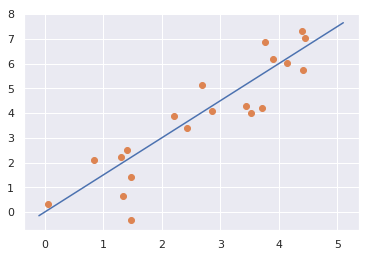

In [10]:
def true_func(x, params):
    y = np.dot(params['w'], polynomial(x, degree=(len(params['w'])-1)))
    return y
def observation_model(x, var=1.0, tfunc_params=None):
    ty = true_func(x, tfunc_params)
    y = np.random.normal(loc=ty, scale=np.sqrt(var), size=1)
    return y

xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*np.random.rand(20) # 純粋にランダムにサンプル

true_func_params = {'w':[0.0, 1.5]}
var_y = 1.0
sample_y = np.array(list(map(lambda x:observation_model(x, var=var_y, tfunc_params=true_func_params), list(sample_x)))).flatten()

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=true_func_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

## 推論

In [11]:
def q_w0(X, Y, e_w1, sig2_y, sig2_w):
    sig2_y_inv = 1.0 / sig2_y
    sig2_w_inv = 1.0 / sig2_w
    N = len(X)
    sig2_n_inv = N*sig2_y_inv + sig2_w_inv
    sig2_n = 1.0 / sig2_n_inv
    mu_n = (np.sum(Y) - np.sum(X)*e_w1) * sig2_y_inv * sig2_n
    return mu_n, sig2_n

def q_w1(X, Y, e_w0, sig2_y, sig2_w):
    sig2_y_inv = 1.0 / sig2_y
    sig2_w_inv = 1.0 / sig2_w
    N = len(X)
    sig2_n_inv = sig2_y_inv * (sample_x**2).sum() + sig2_w_inv
    sig2_n = 1.0 / sig2_n_inv
    mu_n = (np.sum(Y * X) - np.sum(X)*e_w0) * sig2_y_inv * sig2_n
    return mu_n, sig2_n

In [12]:
# initialize
e_w0, e_w1 = 0.0, 0.0

var_w = 0.1
n_iter = 20
mu0s = [e_w0]
mu1s = [e_w1]
for i in tqdm(np.arange(n_iter)):
    mu0_n, var0_n = q_w0(sample_x, sample_y, e_w1, var_y, var_w)
    e_w0 = mu0_n
    
    mu1_n, var1_n = q_w1(sample_x, sample_y, e_w0, var_y, var_w)
    e_w1 = mu1_n
    
    mu0s.append(mu0_n)
    mu1s.append(mu1_n)

100%|██████████| 20/20 [00:00<00:00, 20321.24it/s]


## 推論結果

### 期待値の推移

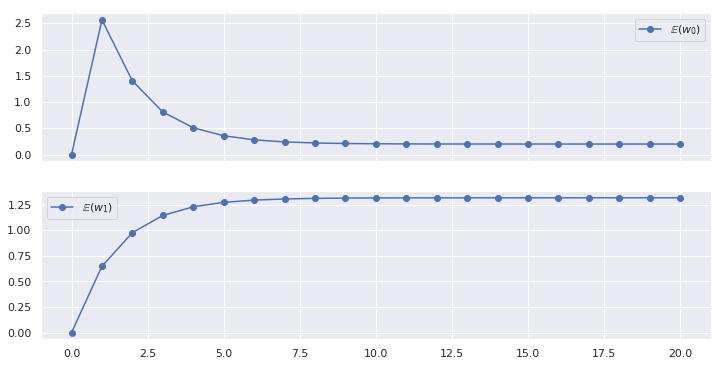

In [13]:
fig = plt.figure(figsize=(12, 6))
ax = fig.subplots(2,1, sharex=True)

ax[0].plot(mu0s, 'o-', label='$\\mathbb{E}(w_0)$')
ax[1].plot(mu1s, 'o-', label='$\\mathbb{E}(w_1)$')
ax[0].legend()
ax[1].legend()

### 事後分布

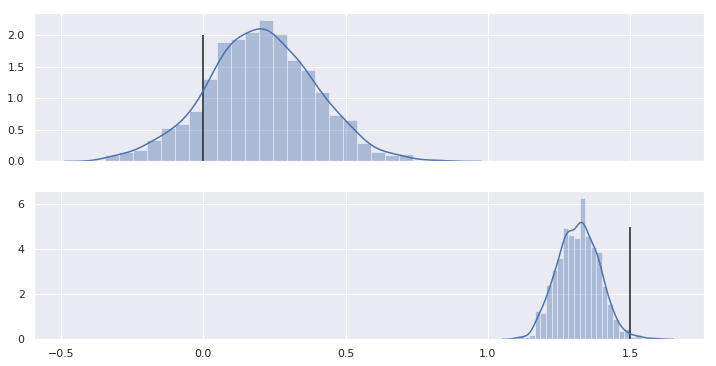

In [14]:
n_sam = 1000
w0_sample = np.random.normal(mu0_n, np.sqrt(var0_n), n_sam)
w1_sample = np.random.normal(mu1_n, np.sqrt(var1_n), n_sam)

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots(2,1, sharex=True)

sns.distplot(w0_sample, ax=ax[0])
sns.distplot(w1_sample, ax=ax[1])
ax[0].vlines(true_func_params['w'][0], 0, 2)
ax[1].vlines(true_func_params['w'][1], 0, 5)

### サンプルした回帰関数

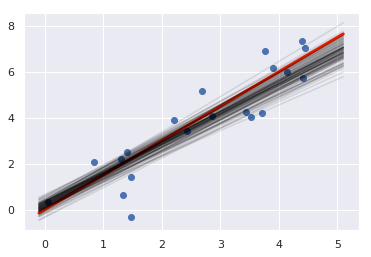

In [15]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=true_func_params), xs))
ax.plot(xs, tys, '-', color='#FF2400', lw=3)
ax.plot(sample_x, sample_y, 'o')

ran = np.random.choice(n_sam, 100)
for r in ran:
    params = {'w':[w0_sample[r], w1_sample[r]]}
    y = true_func(xs, params)
    ax.plot(xs, y, color='#000000', alpha=0.1)